In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize, Grayscale
import torchvision.transforms.functional as TF
import numpy as np
import skimage
import matplotlib.pyplot as plt
import random
import pandas as pd

import urllib.request
import time
#from google.colab import files


In [3]:
def get_mgrid(sidelen, dim=2, depth=1):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])+(torch.linspace(-1, 1, steps=depth),)
    print(tensors[0].size(), tensors[1].size(), tensors[2].size())
    print(len(torch.meshgrid(*tensors)))
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    print("Mgrid step 2: ", mgrid.size())
    mgrid = mgrid.reshape(depth, sidelen**2, dim+1)
    print("Mgrid step 3: ", mgrid.size())
    return mgrid

In [4]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        #output=gradient(output, coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

Creating all the images: color and black_and_white


1.   download images
2.   resize each
3.   save each in RGB and gray (in 2 folders), with new name

To take all images urls from google images:

urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));

In [5]:
!mkdir "imgs"
!mkdir "imgs/temp"
!mkdir "imgs/rgb"
!mkdir "imgs/bw"

mkdir: cannot create directory ‘imgs’: File exists
mkdir: cannot create directory ‘imgs/temp’: File exists
mkdir: cannot create directory ‘imgs/rgb’: File exists
mkdir: cannot create directory ‘imgs/bw’: File exists


In [6]:
!ls imgs/rgb

0.jpg	 132.jpg  165.jpg  198.jpg  22.jpg   262.jpg  295.jpg  39.jpg  71.jpg
100.jpg  133.jpg  166.jpg  199.jpg  230.jpg  263.jpg  296.jpg  3.jpg   72.jpg
101.jpg  134.jpg  167.jpg  19.jpg   231.jpg  264.jpg  297.jpg  40.jpg  73.jpg
102.jpg  135.jpg  168.jpg  1.jpg    232.jpg  265.jpg  298.jpg  41.jpg  74.jpg
103.jpg  136.jpg  169.jpg  200.jpg  233.jpg  266.jpg  299.jpg  42.jpg  75.jpg
104.jpg  137.jpg  16.jpg   201.jpg  234.jpg  267.jpg  29.jpg   43.jpg  76.jpg
105.jpg  138.jpg  170.jpg  202.jpg  235.jpg  268.jpg  2.jpg    44.jpg  77.jpg
106.jpg  139.jpg  171.jpg  203.jpg  236.jpg  269.jpg  300.jpg  45.jpg  78.jpg
107.jpg  13.jpg   172.jpg  204.jpg  237.jpg  26.jpg   301.jpg  46.jpg  79.jpg
108.jpg  140.jpg  173.jpg  205.jpg  238.jpg  270.jpg  302.jpg  47.jpg  7.jpg
109.jpg  141.jpg  174.jpg  206.jpg  239.jpg  271.jpg  303.jpg  48.jpg  80.jpg
10.jpg	 142.jpg  175.jpg  207.jpg  23.jpg   272.jpg  304.jpg  49.jpg  81.jpg
110.jpg  143.jpg  176.jpg  208.jpg  240.jpg  273.jpg  305.jpg  4.jpg

In [7]:
all_urls=pd.read_csv("all_urls.csv", header=None)

In [8]:
all_urls=list(all_urls.iloc[:, 0])

In [9]:
sidelength=32

In [10]:

transform1 = Compose([
        Resize((sidelength, sidelength)),
        #ToTensor(),
        #Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])

transform2 = Compose([
        Resize((sidelength, sidelength)),
        #ToTensor(),
        Grayscale(1),
        #Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])

for i, url in enumerate(all_urls):
    #we download the image
    filename = str(i)+'.jpg'
    urllib.request.urlretrieve(url, "imgs/temp/temp.jpg")
    #and we resize, save in correct folder
    img = Image.fromarray(np.array(Image.open("imgs/temp/temp.jpg")))
    img=transform1(img)
    img.save("imgs/rgb/"+filename)
    #and convert to BW and store in correct folder
    img=transform2(img)
    img.save("imgs/bw/"+filename)

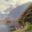

In [11]:
Image.open("imgs/rgb/2.jpg")

In [12]:
def transform_reshape(img, sidelength=sidelength):
    transform = Compose([
        ToTensor(),
        #Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img=transform(img)
    img=img.reshape(-1)
    return img


In [13]:
img=transform_reshape(Image.open("imgs/bw/1.jpg"))
print(img, img.size())

tensor([0.8275, 0.7804, 0.8275,  ..., 0.3608, 0.3529, 0.4039]) torch.Size([1024])


In [14]:
nb_images=len(all_urls)
nb_images

320

<class 'numpy.ndarray'> (32, 32, 3)


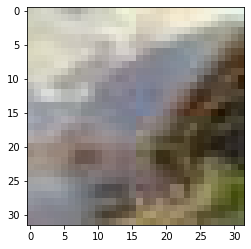

In [15]:
image_index=2

out=transform_reshape(Image.open("imgs/rgb/"+str(image_index)+".jpg"))
res=out.reshape(3, sidelength, sidelength).detach().permute(1, 2, 0).numpy()
print(type(res), res.shape)
plt.imshow(out.reshape(3,sidelength,sidelength).detach().permute(1, 2, 0).numpy())
plt.show()

We create the model, and train it


In [16]:
img_siren = Siren(in_features=sidelength**2, out_features=3*sidelength**2, hidden_features=4*sidelength**2, 
                  hidden_layers=4, outermost_linear=True)
#img_siren.cuda()

In [17]:
losses=[]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 0, Total loss 0.555819


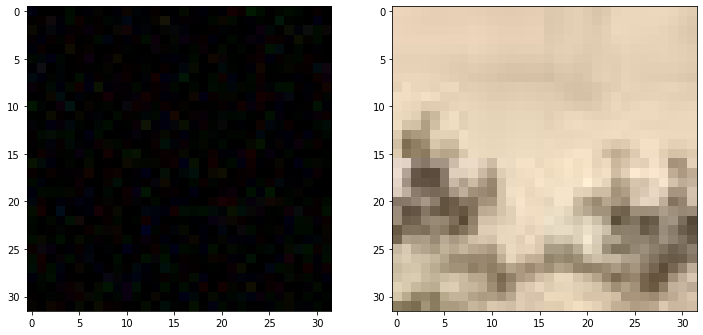

torch.Size([32, 32, 3])
(32, 32, 3)


/home/sebastien/.local/lib/python3.6/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 10, Total loss 0.319943


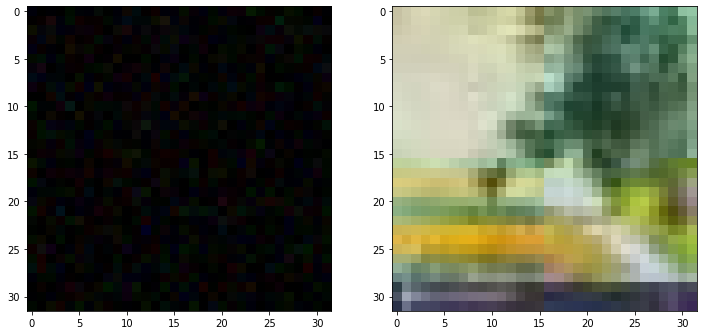

torch.Size([32, 32, 3])
(32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 20, Total loss 0.308873


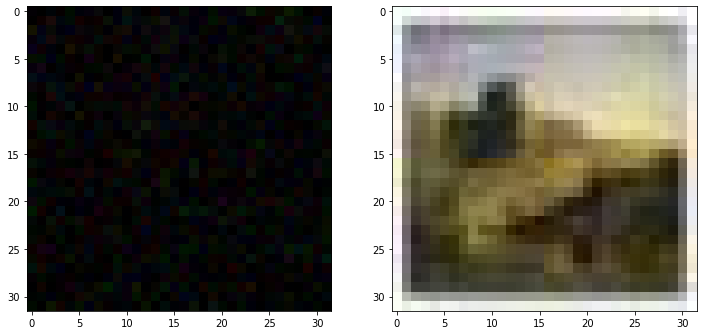

torch.Size([32, 32, 3])
(32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 30, Total loss 0.281742


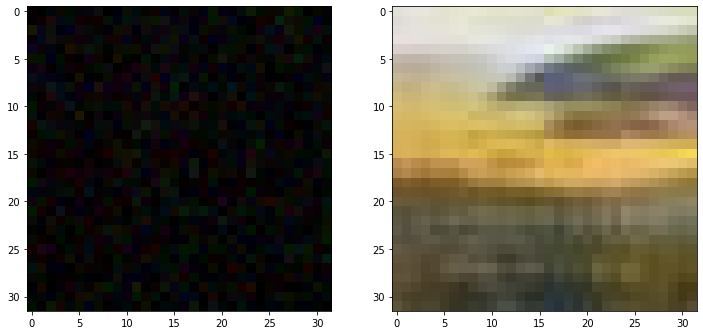

torch.Size([32, 32, 3])
(32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 40, Total loss 0.289310


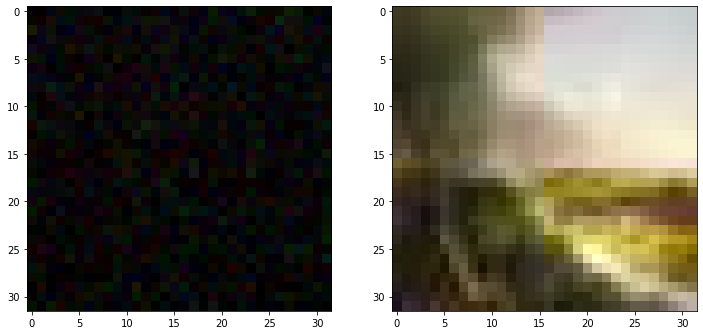

torch.Size([32, 32, 3])
(32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 50, Total loss 0.238442


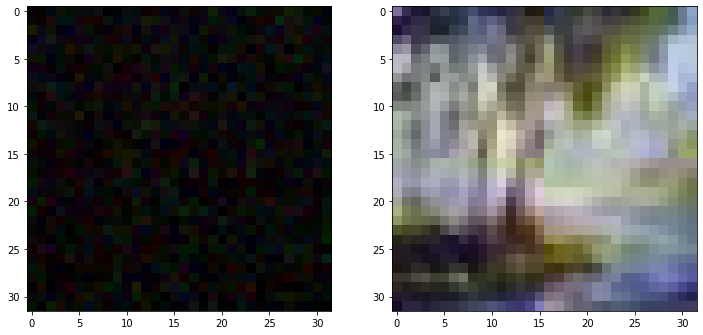

torch.Size([32, 32, 3])
(32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 60, Total loss 0.240658


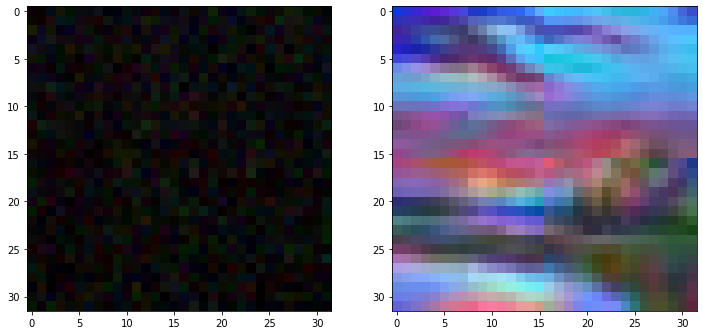

torch.Size([32, 32, 3])
(32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 70, Total loss 0.264497


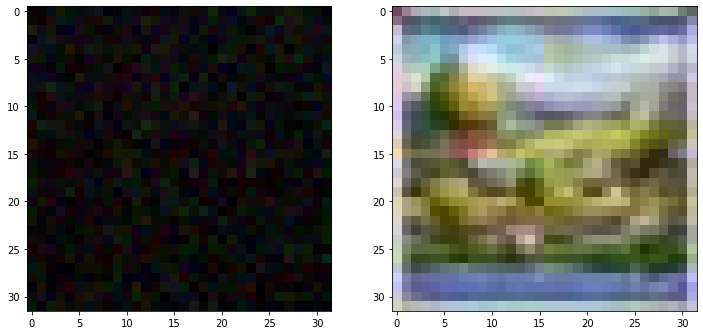

torch.Size([32, 32, 3])
(32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 80, Total loss 0.147456


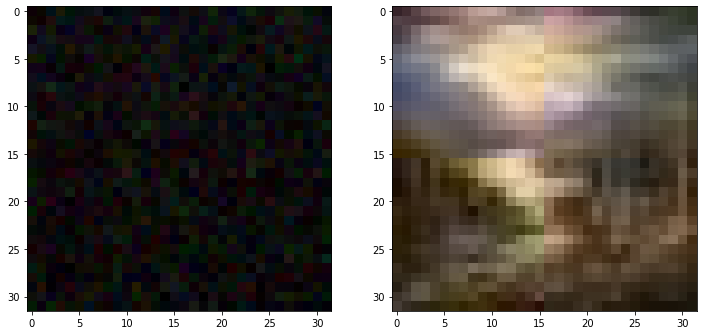

torch.Size([32, 32, 3])
(32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 90, Total loss 0.388268


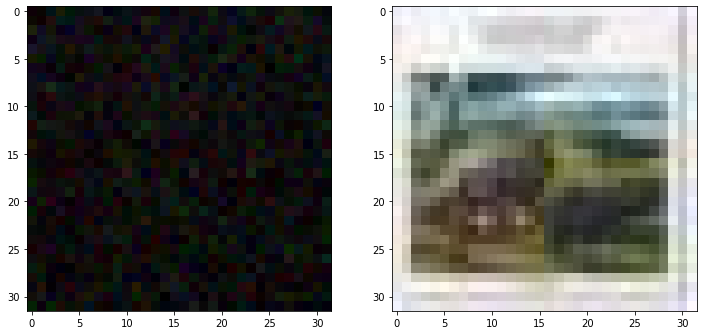

torch.Size([32, 32, 3])
(32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 100, Total loss 0.177091


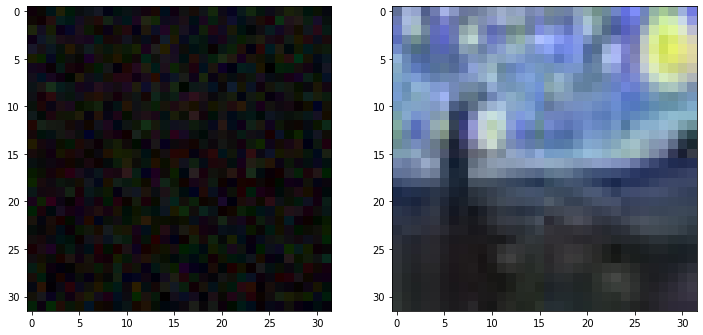

torch.Size([32, 32, 3])
(32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 110, Total loss 0.127379


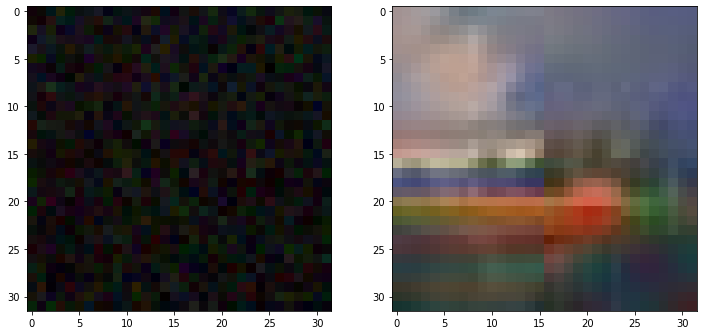

torch.Size([32, 32, 3])
(32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 120, Total loss 0.140510


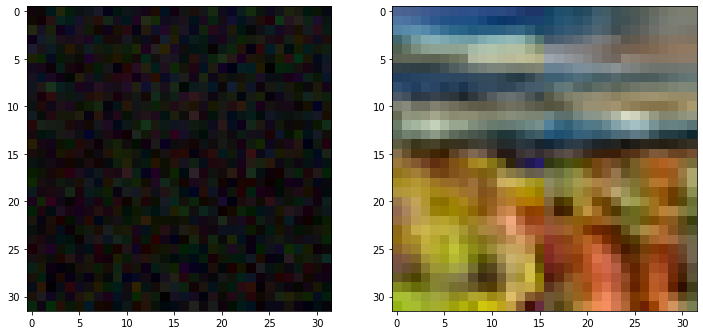

torch.Size([32, 32, 3])
(32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 130, Total loss 0.287203


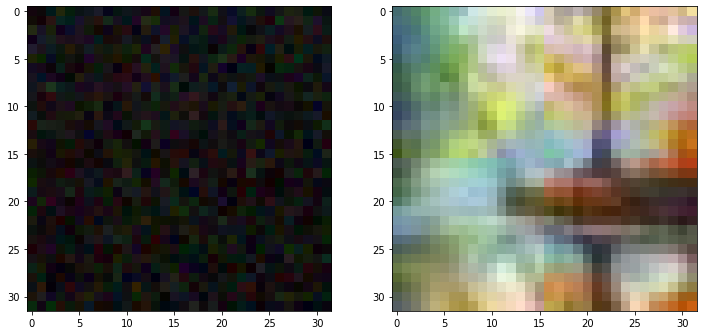

torch.Size([32, 32, 3])
(32, 32, 3)


In [ ]:
total_steps = 300 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 10

optim = torch.optim.Adam(lr=1e-7, params=img_siren.parameters())

for step in range(total_steps):
    
    image_index=random.randint(0, nb_images-1)
    img_input=transform_reshape(Image.open("imgs/bw/"+str(image_index)+".jpg"))
    aim_output=transform_reshape(Image.open("imgs/rgb/"+str(image_index)+".jpg"))


    model_output, coords = img_siren(img_input)
    #print("Output size: ", model_output.size())
    #print("Groundtruth size: ", ground_truth.size())
    
    loss = ((model_output - aim_output)**2).mean()
    
    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))

        fig, axes = plt.subplots(1,2, figsize=(12,6))
        #print("Size image: ", model_output.cpu()[:1, :16384, :].size())
        
        axes[0].imshow(model_output.cpu().reshape(3, sidelength,sidelength).detach().permute(1, 2, 0).numpy())
        axes[1].imshow(aim_output.cpu().reshape(3, sidelength,sidelength).detach().permute(1, 2, 0).numpy())
        plt.show()
        print(model_output.cpu().reshape(sidelength,sidelength, 3).size())
        print(model_output.cpu().reshape(sidelength,sidelength, 3).detach().numpy().shape)

    optim.zero_grad()
    loss.backward()
    optim.step()
    losses.append(loss)

In [ ]:
plt.plot(losses)